In [2]:
import copy
#Расширим функционал класса, который был описан в прошлой лабораторной.
class Acceptor:
  def __init__(self, alphabet, states, initialState, endState):
    self.alphabet = set(alphabet)
    self.states = states
    self.initialState = initialState
    self.endState = set(endState)

  def accept(self, input): 
    state = self.initialState
    for char in input:
      if (char in self.alphabet) == False:
        return False        
      state = states[state][char]
    if (state in self.endState) == True:
      return True
    else:
      return False

  def removeInaccessible(self):
    row = set(self.states[0].keys())
    self.alphabet = self.alphabet - self.alphabet.difference(row)
    diff = list(row.difference(self.alphabet))
    if (len(diff)>0):
      for state in range(len(self.states)):
        for char in diff:
          self.states[state].pop(char)
    visited = set()
    unchecked = set({self.initialState})
    while (1):
      if (len(unchecked) == 0):
        break;
      tmp = list(unchecked)
      visited.add(tmp[0])
      unchecked.remove(tmp[0])
      unchecked.update(set(states[tmp[0]].values()).difference(visited))
    if (len(visited) != len(self.states)):
      for key in list(states.keys()):
        if (key in visited) == False:
          states.pop(key)
    for state in list(self.endState):
      if (state in visited) == False:
       self.endState.remove(state)
       
  #Реализуем минимизацию ДКА Хопкрофта
  def minimize(self):
    #Если автомат не имеет конечных состояний, то можно построить эквивалентный ему автомат 
    #из одного символа, он также никогда не примет выражение
    if len(self.endState) == 0:
      self.states = {0:{'0':0}}
      self.alphabet = {'0'}
      self.initialState = 0
      return
    s0 = set(self.states.keys())
    s1 = set(endState)
    #Список, разбитый на эквивалентные подгруппы
    s = []
    #Изначально это группа выходов и группа всех остальных состояний
    s.append(list(s1))
    s.append(list(s0 - s1))
    #Используется цикл с проверкой на разбиение
    #Если за один проход цикла група не разбилась на новые подгруппы, то цикл останавливается
    while (1):
      check = 1
      prev = copy.deepcopy(s)
      #Рассмотрим отдельно каждую подгруппу
      for sub in s:
        #Подгруппы из одного элемента не могут быть разбиты дальше, поэтому пропускаются
        if (len(sub) < 2):
           continue
        #Попарно сравниваются все состояния подгруппы
        #если 2 состояния эквивалентны, то новое состояние можно сравнивать с любым из них
        for i in range(len(sub)-1):
          #Два состояния, которые проверяются
          el1 = sub[i]
          el2 = sub[i+1]
          #Состояния после отображения (в какие состояния могут перейти выбранные)
          el1Values = list(self.states[el1].values())
          el2Values = list(self.states[el2].values())
          #Недостаточно просто сравнить состояния в которые перешли проверяемые
          #В большинстве случаев требуется проверить, к какой подгруппе эквивалентности
          #принадлежат состояния после отображения, иначе минимизация не будет выполнена корректно
          el1Check = []
          el2Check = []
          for j in range(len(el1Values)):
            for k in range(len(s)):
              if (el1Values[j] in s[k]) == True:
                #Подгруппа, к которой пренадлежат состояния (1) после отображения
                el1Check.append(k)
              if (el2Values[j] in s[k]) == True:
                #Подгруппа, к которой пренадлежат состояния (2) после отображения
                el2Check.append(k)
          #Если элементы не эквивалентны, то один из них требуется переместить в новую подгруппу
          if not(el1Check == el2Check):
            #Требуется проверить всю оставшуюся подгруппу на эквивалентность второму элементу.
            #Второй тут используется для простоты алгоритма. Если неэквивалентен всей группе был, к примеру, первый элемент,
            #то вся оставшаяся подгруппа будет эквивалентна второму элементу, и разбиение произойдет корректно
            #Задается подгруппа, которая после будет удалена из текущей и выделена в отдельную
            equiv = [el2]
            if (i+1 <= len(sub)-2):
              for ii in range(i+2, len(sub)):
                #Известным уже образом проверяются все элементы на эевивалентность заданному
                el3 = sub[ii]
                el3Values = list(self.states[el3].values())
                el3Check = []
                for j in range(len(el3Values)):
                  for k in range(len(s)):
                    if (el3Values[j] in s[k]) == True:
                      #Подгруппа, к которой пренадлежат состояния после отображения
                      el3Check.append(k)
                      #Если элемент эквивалентен текущему, то он также впереностися в новую подгруппу
                if (el3Check == el2Check):
                  equiv = equiv + [el3]
            #Если элемент был последним в подгруппе, то предыдущая проверка, очевидно, не выполняется
            #И все неэквивалентные элементы переносятся в новую подгруппу
            for i in equiv:
              sub.remove(i)
            s.append(equiv)
            check =0
            break
        #Если было выполнено хотя бы одно разбиение, то логично было бы начать процесс сначала
        if (check == 0):
          break
      #Хоть можно обойтьись и исключительно предыдущей булевой переменной, на всякий случай, из основного цикла выход
      #основан на сравнении подгрупп до и после одного прохода цикла
      if (prev == s):
        break

    #Эквивалентные подгруппы объединяются в одино состояние
    while(1):
      check = 1
      for sub in s:
        #Подгруппы из одного состояния, очевидно, не объединяются
        if(len(sub) < 2):
          continue
        check = 0
        #Для каждой подгруппы объединяем два соседних состояния (большее с меньшим)
        for i in range(len(sub)-1):
          un1 = sub[i]
          un2 = sub[i+1]
          #Если "второе" из состояний являлось начальным, то начальным становится другое по объединению
          if (self.initialState == un2):
            self.initialState = un1
          #Аналогично проверяются и конечные состояния
          self.endState = self.endState - set([un2])
          #Из двух эквивалентных элементов 1 удаляется
          self.states.pop(un2)
          #Все отображения переводятся на оставшийся эквивалентный элемент
          for i in self.states.values():
            keys = list(i.keys())
            for j in range(len(i.values())):
              if list(i.values())[j] == un2:
                i[keys[j]] = un1
          #Из текущей подгруппы удалются все несуществующие состояния состояния
          sub.remove(un2)
          break
      #Если все подгруппы состоят из одного элемента, значит объединение завершилось
      if(check == 1):
        break
#Рассмотрим несколько примеров:
 

Пример первый:
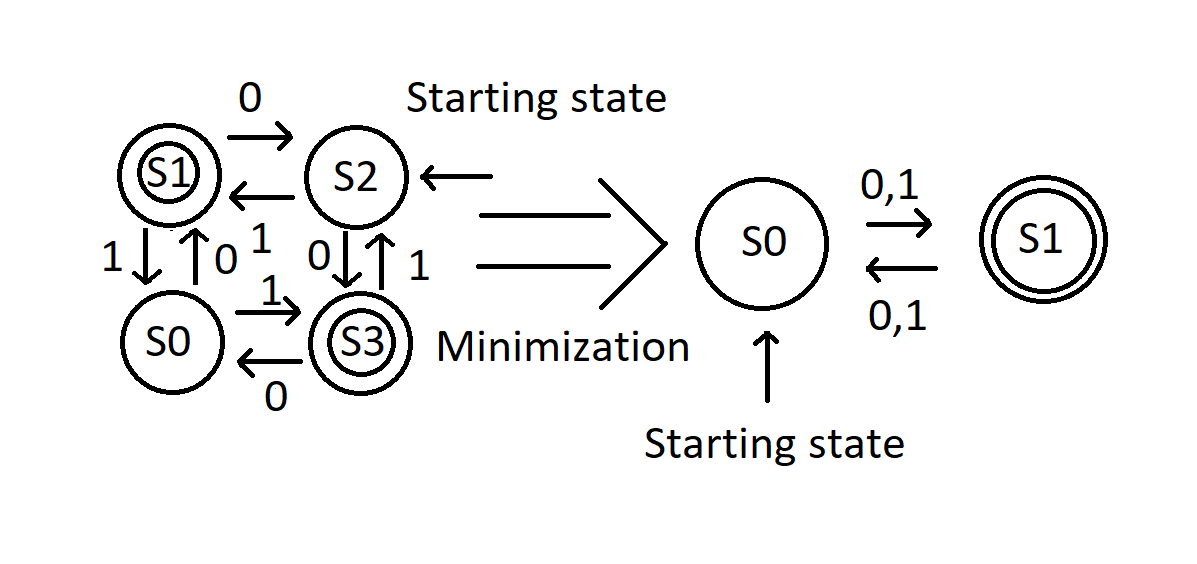

In [3]:
alphabet = {'1', '0'}

states = {0:{'0':1, '1':3},
       1:{'0':2, '1':0},
       2:{'0':3, '1':1},
       3:{'0':0, '1':2},}


initialState = 2

endState = {3, 1}

acceptor = Acceptor(alphabet, states, initialState, endState)
acceptor.removeInaccessible()
acceptor.minimize()
print(acceptor.alphabet)
print(acceptor.states)
print(acceptor.initialState)
print(acceptor.endState)

{'0', '1'}
{0: {'0': 1, '1': 1}, 1: {'0': 0, '1': 0}}
0
{1}


Пример второй:
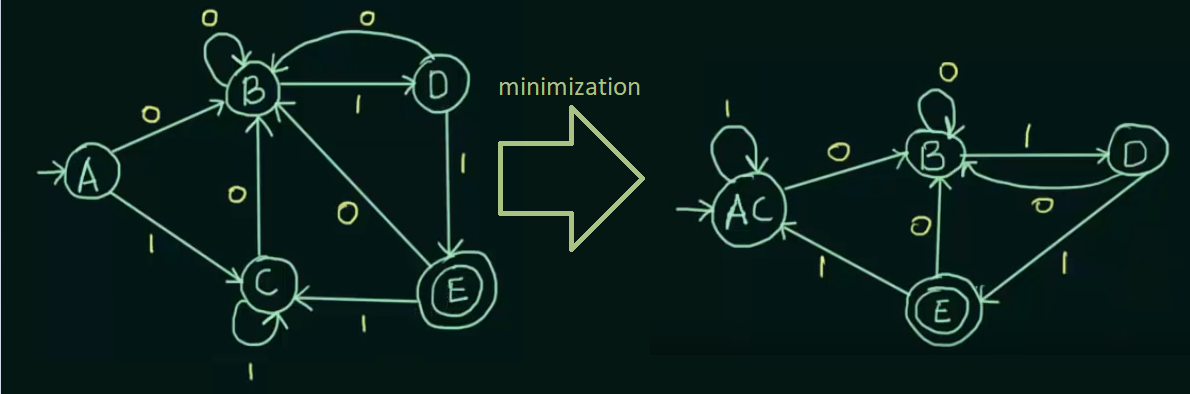

In [4]:
alphabet = {'1', '0'}
states = {0:{'0':1, '1':2},
       1:{'0':1, '1':3},
       2:{'0':1, '1':2},
       3:{'0':1, '1':4},
       4:{'0':1, '1':2}}
#Но при этом начальное состояние будет, к примеру S3
initialState = 0
endState = {4}
acceptor = Acceptor(alphabet, states, initialState, endState)
acceptor.removeInaccessible()
acceptor.minimize()
print(acceptor.alphabet)
print(acceptor.states)
print(acceptor.initialState)
print(acceptor.endState)

{'0', '1'}
{0: {'0': 1, '1': 0}, 1: {'0': 1, '1': 3}, 3: {'0': 1, '1': 4}, 4: {'0': 1, '1': 0}}
0
{4}


Пример третий:
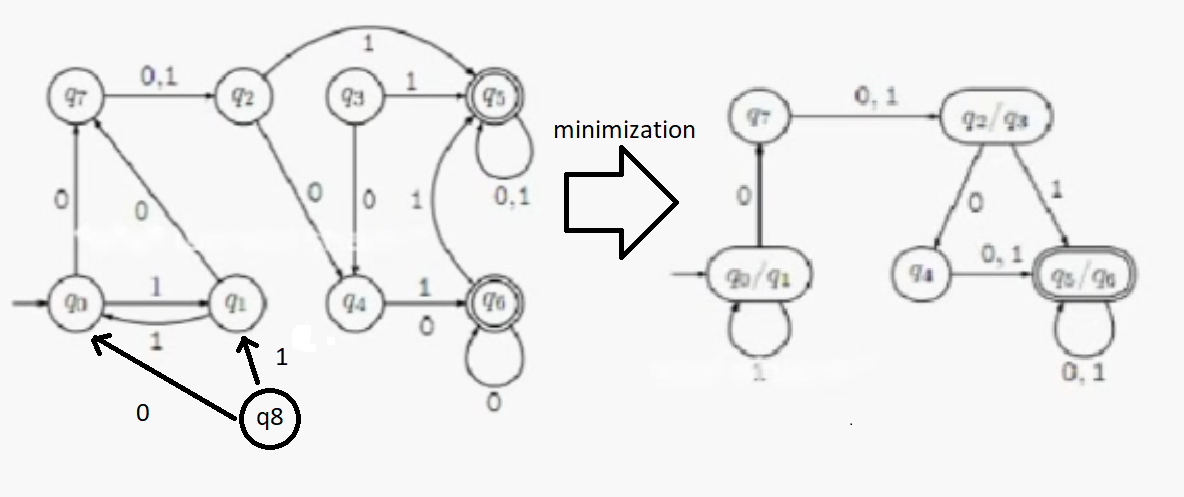

In [5]:
alphabet = {'1', '0'}
states = {0:{'0':7, '1':1},
       1:{'0':7, '1':0},
       2:{'0':4, '1':5},
       3:{'0':4, '1':5},
       4:{'0':6, '1':6},
       5:{'0':5, '1':5},
       6:{'0':6, '1':5},
       7:{'0':2, '1':2},
       8:{'0':0, '1':1}}

initialState = 0
endState = {5, 6}
acceptor = Acceptor(alphabet, states, initialState, endState)
acceptor.removeInaccessible()
acceptor.minimize()
print(acceptor.alphabet)
print(acceptor.states)
print(acceptor.initialState)
print(acceptor.endState)

{'0', '1'}
{0: {'0': 7, '1': 0}, 2: {'0': 4, '1': 5}, 4: {'0': 5, '1': 5}, 5: {'0': 5, '1': 5}, 7: {'0': 2, '1': 2}}
0
{5}
